# Análise de Tópicos

#### Importação de Bibliotecas

In [1]:
import pandas as pd
import spacy
from bertopic import BERTopic

from collections import Counter

import re
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from wordcloud import WordCloud

from unidecode import unidecode

In [3]:
from gensim.utils import simple_preprocess

In [4]:
from transformers import AutoTokenizer  # Or BertTokenizer
from transformers import AutoModelForSequenceClassification  # Or BertForPreTraining for loading pretraining heads
from transformers import AutoModelForTokenClassification
from transformers import AutoModelForCausalLM
from transformers import BitsAndBytesConfig
from transformers import TrainingArguments
from transformers import AutoModel  # or BertModel, for BERT without pretraining heads
from transformers import pipeline, logging
import torch
import transformers
import torch.nn as nn
from tqdm import tqdm
# import bitsandbytes as bnb
# import accelerate
# from datasets import Dataset
# from peft import LoraConfig, PeftConfig
# from trl import SFTTrainer
# from trl import setup_chat_format

#### Leitura do arquivo

O arquivo com os dados da avaliação do restaurante Guacamole, retirados da plataforma TripAdvisor em https://www.tripadvisor.com.br/Restaurant_Review-g303506-d3399400-Reviews-or2000-Guacamole_Cocina_Mexicana_Barra_da_Tijuca-Rio_de_Janeiro_State_of_Rio_de_J.html possui os comentários dos usuários em relação às suas respectivas avaliações do restaurante e a data de tal avaliação.

In [5]:
df_reviews_ecommerce = pd.read_csv("concatenated.csv", low_memory=False)

In [10]:
dataset_names = df_reviews_ecommerce["dataset"].unique()
df_olist = df_reviews_ecommerce[df_reviews_ecommerce['dataset'] == 'olist']
df_olist = df_olist[['review_text','rating']]
df_olist.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41744 entries, 2659357 to 2701100
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   review_text  41744 non-null  object 
 1   rating       41744 non-null  float64
dtypes: float64(1), object(1)
memory usage: 978.4+ KB


In [9]:
df_olist = df_olist.dropna()
df_olist = df_olist.drop_duplicates()
df_olist = df_olist.reset_index(drop=True)
df_olist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37564 entries, 0 to 37563
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   review_text  37564 non-null  object 
 1   rating       37564 non-null  float64
dtypes: float64(1), object(1)
memory usage: 587.1+ KB


In [ ]:
df_reviews = pd.read_csv("guacamole_reviews.csv")
df_reviews.head()

In [ ]:
df_comments = df_reviews["Review"]
df_dates = df_reviews["Date"]

In [ ]:
df_reviews.info()

#### Limpeza dos dados

As funções em seguir estão relacionadas ao pré-processamento de texto em linguagem natural utilizando o português. 
- A função ```remove_stopwords``` realiza a remoção de palavras de parada (stopwords) de textos em português. 
- A função ```lemmatizer``` realiza a lematização de um texto em português, preservando apenas certas classes gramaticais.
- A função ```parse_date``` realiza a conversão de uma data no formato "(dia) de (mês) de (ano)" para "YYYY-MM-DD".

In [11]:
import nltk
import spacy
nltk.download(["stopwords", "rslp"])

PT_STOPWORDS = nltk.corpus.stopwords.words('portuguese')

REGEX = [
    {'input': r'/\d+/g', 'output': r' '},               # removing digits
    {'input': r'[^\w\s]', 'output': r' '},              # removing punctuationon
    {'input': r'\n', 'output': r' '},                   # removing line breaks
    {'input': r'\b\w{1,2}\b', 'output': r''},           # removing short words (1 or 2 characters)
]

# spell = SpellChecker(language="pt")
# def apply_spelling_correction(text):
#     corrected_text = " ".join([spell.correction(word) or word for word in text.split()])
#     return corrected_text

def regex_treatment(text):
    for pattern in REGEX:
        text = re.sub(pattern['input'], pattern['output'], text)
    return text.strip().lower()

def remove_stopwords(text):
    words = simple_preprocess(text)
    phrase_adjusted = " ".join([word for word in words if word not in PT_STOPWORDS])
    return phrase_adjusted.lower()

spacy_lemma = spacy.load("pt_core_news_md")

# Ignoring VERBs, ADVs, ADJs, PROPNs (...)
def lemmatizer(text, postags_permit=['NOUN']):
    """https://spacy.io/api/annotation"""
    doc = spacy_lemma(text.lower())
    doc_lemma = " ".join([token.lemma_ for token in doc if token.pos_ in postags_permit])
    return doc_lemma

def remove_accentuation(text):
    return unidecode(text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\isabe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\isabe\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


Aplicamos as mudanças nos comentários das avaliações e adicionamos uma nova coluna no DataFrame com os resultados obtidos.

In [ ]:
%%time

df_reviews["Review_Topic"] = df_reviews["Review"].apply(regex_treatment)
df_reviews["Review_Topic"] = df_reviews["Review_Topic"].apply(remove_stopwords)
df_reviews["Review_Topic"] = df_reviews["Review_Topic"].apply(lemmatizer)
df_reviews["Review_Topic"] = df_reviews["Review_Topic"].apply(remove_accentuation)

In [ ]:
df_reviews["Review_Entity"] = df_reviews["Review"].apply(regex_treatment)
df_reviews["Review_Entity"] = df_reviews["Review"].apply(remove_accentuation)

In [12]:
%%time

df_olist["Review_Topic"] = df_olist["review_text"].apply(regex_treatment)
df_olist["Review_Topic"] = df_olist["Review_Topic"].apply(remove_stopwords)
df_olist["Review_Topic"] = df_olist["Review_Topic"].apply(lemmatizer)
df_olist["Review_Topic"] = df_olist["Review_Topic"].apply(remove_accentuation)

CPU times: total: 3min 5s
Wall time: 3min 18s


In [ ]:
df_comments = df_reviews["Review_Topic"]
doc_comments = df_comments.to_list()
doc_comments[:5]

In [13]:
df_comments = df_olist["Review_Topic"]
doc_comments = df_comments.to_list()
doc_comments[:5]

['prazo', 'compra prazo produto anuncio expectativa', 'custo', '', 'capa capa']

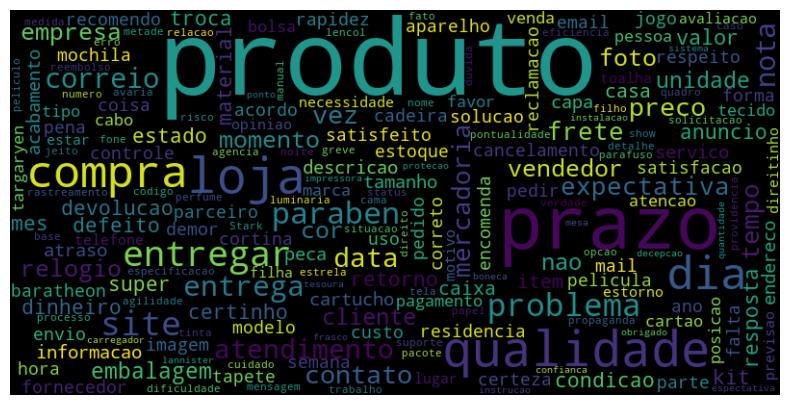

In [17]:
from wordcloud import WordCloud
wordcloud_text = ' '.join(df_olist["Review_Topic"].astype(str))

wordcloud = WordCloud(width=800, height=400, random_state=15, max_font_size=110, max_words=200, collocations=False).generate(wordcloud_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### BERTopic

Utilizando os parâmetros padronizados do BERTopic, obteremos os tópicos, do mais frequente ao menos frequente. 
- Se desejamos visualizar a frequência de cada tópico, podemos utilizar ```get_topic_freq()``` para obter os valores.
- Se desejamos visualizar as informações de todos os tópicos obtidos, podemos utilizar ```get_topic_info()``` para obter o número de documentos que estão relacionados a cada tópico e o nome dele, além de suas representações textuais.
- Se desejamos visualizar as informações de um tópico em específico, podemos utilizar o ```get_topic()``` para obter as palavras que pertencem ao tópico e os seus _scores_ de c-TF-IDF, ou seja, uma representação numérica do quão frequente e única aquela palavra é para o documento.

Vale lembrar que o tópico de número **-1** refere-se a todos os valores discrepantes e normalmente deve ser ignorado.

In [18]:
%%time
import numpy as np
from umap import UMAP

MAX_LEN = 175
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
topic_model = BERTopic(language="portuguese", calculate_probabilities=True, verbose=True, min_topic_size=50)
topics, probs = topic_model.fit_transform(doc_comments)

2024-05-05 15:52:19,044 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/1305 [00:00<?, ?it/s]

2024-05-05 15:57:08,734 - BERTopic - Embedding - Completed ✓
2024-05-05 15:57:08,741 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-05-05 15:59:34,430 - BERTopic - Dimensionality - Completed ✓
2024-05-05 15:59:34,510 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-05-05 16:01:32,502 - BERTopic - Cluster - Completed ✓
2024-05-05 16:01:32,675 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-05-05 16:01:33,634 - BERTopic - Representation - Completed ✓


CPU times: total: 33min 10s
Wall time: 9min 15s


In [ ]:
freq = topic_model.get_topic_info(); freq.head(5)

In [ ]:
topic_model.get_topic_freq().head()

In [ ]:
topic_model.get_topic(3)

In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.visualize_documents(doc_comments)

#### Visualização dos tópicos

In [ ]:
topic_model.visualize_barchart(top_n_topics=20)

Com o auxílio do ChatGPT para uma definição em uma única frase sobre o que se trata os primeiros 5 tópicos, temos que:
- **Tópico 0**: Este tópico analisado aborda aspectos relacionados a comida mexicana, com ênfase em guacamole, destacando a qualidade de restaurantes e a atmosfera agradável.
- **Tópico 1**: Este tópico analisado destaca a qualidade do atendimento e do ambiente, ressaltando a excelência do lugar, com ênfase em uma experiência gastronômica muito boa e maravilhosa.
- **Tópico 2**: Esse tópico analisado aborda a influência positiva da música no ambiente, ressaltando a qualidade do atendimento e a excelência, criando uma atmosfera agradável para comer e animar.
- **Tópico 3**: Esse tópico analisado trata da celebração de aniversários e comemorações em um ambiente amigável, destacando a importância do lugar, a qualidade do ambiente e do atendimento, tornando a experiência muito boa para amigos e amigas.
- **Tópico 4**: Este tópico analisado destaca a apreciação de bebidas, especialmente drinks e cervejas, ressaltando a importância do atendimento e a qualidade do ambiente, proporcionando uma experiência muito boa para comer e bebidas geladas.

In [ ]:
topic_model.visualize_hierarchy()

#### DataFrame com informações completas

In [ ]:
df_topics = df_reviews.copy()

df_topics["Topics"] = topics

topic_name = freq.drop(columns=["Count"]).rename(columns={"Topic": "Topics", "Name": "Names"})
df_topics = df_topics.merge(topic_name, how="left")

df_topics.head()

# Análise de Sentimentos

Utilizando um modelo pré-treinado público baseado no BERT, faremos a extração das informações dos sentimentos de cada uma das avaliações.

In [ ]:
%%time

model = AutoModelForSequenceClassification.from_pretrained('lxyuan/distilbert-base-multilingual-cased-sentiments-student')
tokenizer = AutoTokenizer.from_pretrained('lxyuan/distilbert-base-multilingual-cased-sentiments-student', do_lower_case=False)
sentiment_task = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, return_all_scores=True)

#### Classificação das avaliações e salvamento dos resultados no DataFrame

Para a extração dos sentimentos e gravação das informações dos valores no DataFrame, utilizaremos duas funções:
- Para captura dos sentimentos e gravação no DataFrame na forma padrão de entrega dos resultados, chamaremos primeiro a pipeline do processo, chamada ```sentiment_task``` e armazenaremos os valores em uma coluna chamada "Sentiments".
- Feito isso, iremos separar os valores de acordo com o sentimento e armazenaremos cada um deles no DataFrame final utilizando a função ```extract_sentiment_scores()```.

In [ ]:
def extract_sentiment_scores(predictions, sentiment_label):
    if isinstance(predictions, list) and predictions:
        for item in predictions[0]:
            if item['label'] == sentiment_label:
                return item['score']
    return 0

In [ ]:
%%time

df_topics["Sentiments"] = df_topics["Review"].apply(lambda x: sentiment_task(x))

In [ ]:
df_topics["Positive"] = df_topics["Sentiments"].apply(lambda x: extract_sentiment_scores(x, 'positive'))
df_topics["Neutral"] = df_topics["Sentiments"].apply(lambda x: extract_sentiment_scores(x, 'neutral'))
df_topics["Negative"] = df_topics["Sentiments"].apply(lambda x: extract_sentiment_scores(x, 'negative'))

df_topics = df_topics.drop(columns=["Sentiments"])

In [ ]:
df_topics.head()

In [ ]:
df_topics.to_csv('guacamole_topics_sentiment.csv', index=False)

Feito isso, iremos calcular a média dos valores de cada um dos três sentimentos para os tópicos em questão e, no final de tudo, veremos qual é o maior valor dentre os três para definirmos o sentimento final para o tópico analisado.

In [ ]:
df_topic_sentiment = df_topics.groupby('Topics').agg({'Neutral': 'mean', 'Positive': 'mean', 'Negative': 'mean'})
df_topic_sentiment = df_topic_sentiment.reset_index()
df_topic_sentiment.head()

In [ ]:
score_cols = ['Neutral', 'Positive', 'Negative']
df_topic_sentiment['Highest Score'] = df_topic_sentiment[score_cols].max(axis=1)

def get_sentiment(row):
    if row['Positive'] == row['Highest Score']:
        return 'Positive'
    elif row['Negative'] == row['Highest Score']:
        return 'Negative'
    else:
        return 'Neutral'

df_topic_sentiment['Topic Sentiment'] = df_topic_sentiment.apply(get_sentiment, axis=1)
df_topic_sentiment.head()

In [ ]:
score_cols = ['Neutral', 'Positive', 'Negative']
df_topics['Highest Score'] = df_topics[score_cols].max(axis=1)

def get_sentiment(row):
    if row['Positive'] == row['Highest Score']:
        return 'Positive'
    elif row['Negative'] == row['Highest Score']:
        return 'Negative'
    else:
        return 'Neutral'
df_topics['Sentiment'] = df_topics.apply(get_sentiment, axis=1)
df_topics.head()

In [ ]:
topic_sentiment_counts = df_topics['Sentiment'].value_counts()

for topic_sentiment, count in topic_sentiment_counts.items():
    print("Valor:", topic_sentiment)
    print("Frequência:", count)
    print()

In [ ]:
df_topic_sentiment.to_csv('topics_sentiment.csv', index=False)

# Extração de Entidade Nomeada

In [ ]:
model_ner = AutoModelForTokenClassification.from_pretrained('51la5/roberta-large-NER')
tokenizer_ner = AutoTokenizer.from_pretrained('51la5/roberta-large-NER', do_lower_case=False)
ner_task = pipeline("ner", model=model_ner, tokenizer=tokenizer_ner)

In [ ]:
def classify_ner(text):
    """
    Token classification function using a pretrained model.

    Parameters:
    - text: Input text to be tokenized and classified.

    Returns:
    List of tuples containing predicted pairs (token, label) for the input text.

    Example:
    Input:  "Julia is tired of living in London."
    Output: [('Julia', 'B-PESSOA'), ('is', 'O'), ('tired', 'O'), ('of', 'O'),
            ('living', 'O'), ('in', 'O'), ('London', 'B-LOCAL'), ('.', 'O')]
    """

    inputs = tokenizer_ner(text, max_length=512, truncation=True, return_tensors="pt")
    tokens = inputs.tokens()

    outputs = model_ner(**inputs).logits
    predictions = torch.argmax(outputs, dim=2)

    results = []

    for token, prediction in zip(tokens, predictions[0].numpy()):
        label = model_ner.config.id2label.get(prediction, 'O')
        if label != 'O':
            results.append((token, label))

    return results

In [ ]:
%%time

df_topics["Token Predictions"] = df_topics["Review_Entity"].apply(classify_ner)

In [ ]:
def merge_tokens(token_predictions):
    """
    Function to merge consecutive tokens that start with "_" and have the same label.

    Parameters:
    - token_predictions: List of tuples containing predicted pairs (token, label).

    Returns:
    List of merged tuples where consecutive tokens starting with "_"
    and having the same label are combined.

    Example:
    Input:  [('▁Mathe', 'I-PER'), ('us', 'I-PER')]
    Output: [('▁Matheus', 'I-PER')]
    """

    merged_results = []
    current_token = ""
    current_label = ""

    for token, label in token_predictions:
        if token.startswith("▁"):
            if current_token:
                merged_results.append((current_token, current_label))
            current_token = token[1:]
            current_label = label
        else:
            current_token += token
            current_label = label

    if current_token:
        merged_results.append((current_token, current_label))

    return merged_results

In [ ]:
%%time

df_topics["Token Predictions Corrected"] = df_topics["Token Predictions"].apply(merge_tokens)

In [ ]:
token_predictions_corrected = df_topics["Token Predictions Corrected"]

flat_list = [item for sublist in token_predictions_corrected for item in sublist]

counter = Counter(flat_list)

most_common_elements = counter.most_common(20)

most_common_elements

In [ ]:
df_topics = df_topics.drop(columns=["Token Predictions"])

In [ ]:
import pandas as pd
from collections import Counter

df_filtered = df_topics[df_topics["Token Predictions Corrected"].apply(lambda x: bool(x))]

def most_common_values(lst, n=5):
    counter = Counter(lst)
    if counter:
        most_common = counter.most_common(n)
        return most_common
    else:
        return []

result = df_filtered.groupby("Topics")["Token Predictions Corrected"].agg(lambda x: most_common_values([item for sublist in x for item in sublist])).reset_index()
result.head()

In [ ]:
result.to_csv('topics_ner.csv', index=False)

In [ ]:
df_topics.head()

### Montagem do DataFrame completo

União das informações dos três DataFrames criados para a construção do completo.

In [ ]:
df_info = df_topics[['Topics', 'Representation']].copy()
df_info = pd.merge(df_info, df_topic_sentiment, on='Topics', how='left')
df_info = pd.merge(df_info, result, on='Topics', how='left')
df_info = df_info.drop_duplicates(subset='Topics')

In [ ]:
topic_freq = topic_model.get_topic_freq()
df_info = pd.merge(df_info, topic_freq, left_on='Topics', right_on='Topic', how='left')

In [ ]:
df_info = df_info.sort_values(by='Topics')
df_info = df_info.drop(columns='Topic')

Obtenção do DataFrame completo.

In [ ]:
df_info.head()

In [ ]:
df_info.to_csv('complete_info_topics.csv', index=False)

Obtenção dos DataFrames das informações das avaliações.

In [ ]:
df_topic_0 = df_topics[df_topics['Topics'] == 0]
df_topic_1 = df_topics[df_topics['Topics'] == 1]
df_topic_2 = df_topics[df_topics['Topics'] == 2]
df_topic_3 = df_topics[df_topics['Topics'] == 3]
df_topic_4 = df_topics[df_topics['Topics'] == 4]
df_topic_5 = df_topics[df_topics['Topics'] == 5]
df_topic_9 = df_topics[df_topics['Topics'] == 9]

In [ ]:
df_topic_0.to_csv('df_topic_0.csv', index=False)
df_topic_1.to_csv('df_topic_1.csv', index=False)
df_topic_2.to_csv('df_topic_2.csv', index=False)
df_topic_3.to_csv('df_topic_3.csv', index=False)
df_topic_4.to_csv('df_topic_4.csv', index=False)
df_topic_5.to_csv('df_topic_5.csv', index=False)
df_topic_9.to_csv('df_topic_9.csv', index=False)

In [ ]:
sentiment_counts = df_topics.groupby(['Topics', 'Sentiment']).size().reset_index(name='count')

In [ ]:
sentiment_counts.head(18)

In [ ]:
df_topics.head()

In [ ]:
def entidade_mais_frequente_por_topico(df):
    entidade_por_topico = {'topic': [], 'entidades_mais_frequentes': [], 'frequencias': []}

    grupos = df.groupby('Topics')

    for nome_grupo, grupo in grupos:
        contagem_entidades = {}

        for index, row in grupo.iterrows():
            for token_pred in row['Token Predictions Corrected']:
                entidade = token_pred[0]
                contagem_entidades[entidade] = contagem_entidades.get(entidade, 0) + 1

        # Obter as 5 entidades mais frequentes e suas frequências
        entidades_mais_frequentes = sorted(contagem_entidades, key=contagem_entidades.get, reverse=True)[:10]
        frequencias = [contagem_entidades[entidade] for entidade in entidades_mais_frequentes]

        # Salvar as entidades e frequências como strings separadas por vírgula
        entidades_string = ', '.join(entidades_mais_frequentes)
        frequencias_string = ', '.join(map(str, frequencias))

        entidade_por_topico['topic'].append(nome_grupo)
        entidade_por_topico['entidades_mais_frequentes'].append(entidades_string)
        entidade_por_topico['frequencias'].append(frequencias_string)

    df_entidade_mais_frequente = pd.DataFrame(entidade_por_topico)

    return df_entidade_mais_frequente

df_entidade_mais_frequente = entidade_mais_frequente_por_topico(df_topics)
df_entidade_mais_frequente

In [ ]:
df_entidade_mais_frequente.to_csv('df_entidade_mais_frequente.csv', index=False)

In [ ]:
def mostrar_reviews_por_sentimento_e_topico(df, topico, output_file):
    df_topico = df[df['Topics'] == topico]

    with open(output_file, 'w') as file:
        for sentimento in ['Positive', 'Neutral', 'Negative']:
            file.write(f"Reviews com sentimento '{sentimento}' no tópico '{topico}':\n")
            
            df_sentimento = df_topico[df_topico['Sentiment'] == sentimento]
            df_sentimento['Review'] = df_sentimento['Review'].str.replace('\n', ' ')
            
            for i, review_text in enumerate(df_sentimento['Review'].head(5), start=1):
                file.write(f"{i}. {review_text}\n")
            file.write('\n')

# Exemplo de uso:
mostrar_reviews_por_sentimento_e_topico(df_topics, 2, 'review_guacamole_2.txt')